# Modelo GRNN

## Importacion de las bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import itertools

from neupy import algorithms

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## Importacion de los Datasets

In [5]:
# Dataset de entrenamiento
df_Nizanda = pd.read_csv('./Datasets/Nizanda_D1.csv')
df_Nizanda

,Day,Month,Year,Hour,Wind Speed m/s,Wind Direction,High Wind Speed m/s,High Wind Direction,Date
0,1.0,1.0,2017.0,0.0,3.1,N,11.2,NW,2017-01-01 00:00:00
1,1.0,1.0,2017.0,1.0,3.1,WNW,11.2,WNW,2017-01-01 01:00:00
2,1.0,1.0,2017.0,2.0,2.7,WNW,10.7,WNW,2017-01-01 02:00:00
3,1.0,1.0,2017.0,3.0,3.1,WNW,10.7,WNW,2017-01-01 03:00:00
4,1.0,1.0,2017.0,4.0,3.1,WNW,12.5,WNW,2017-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
26166,31.0,12.0,2022.0,19.0,2.2,NE,8.5,W,2022-12-31 19:00:00
26167,31.0,12.0,2022.0,20.0,1.8,NNE,7.6,ENE,2022-12-31 20:00:00
26168,31.0,12.0,2022.0,21.0,1.8,ENE,6.7,NW,2022-12-31 21:00:00
26169,31.0,12.0,2022.0,22.0,2.2,NE,8.5,NE,2022-12-31 22:00:00


In [6]:
df_Prueba = pd.read_csv('./Datasets/Nizanda_D2023.csv')
df_Prueba

,Day,Month,Year,Hour,Wind Speed m/s,Wind Direction,High Wind Speed m/s,High Wind Direction,Date
0,1.0,1.0,2023.0,0.0,2.2,NE,7.6,NW,2023-01-01 00:00:00
1,1.0,1.0,2023.0,1.0,1.8,NE,6.7,N,2023-01-01 01:00:00
2,1.0,1.0,2023.0,2.0,2.2,NE,7.6,NNE,2023-01-01 02:00:00
3,1.0,1.0,2023.0,3.0,3.6,NE,8.0,N,2023-01-01 03:00:00
4,1.0,1.0,2023.0,4.0,2.7,NE,7.6,NNE,2023-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
8755,31.0,12.0,2023.0,19.0,3.6,NE,13.4,N,2023-12-31 19:00:00
8756,31.0,12.0,2023.0,20.0,4.0,NE,11.6,N,2023-12-31 20:00:00
8757,31.0,12.0,2023.0,21.0,3.6,NE,11.2,NNW,2023-12-31 21:00:00
8758,31.0,12.0,2023.0,22.0,3.1,ENE,12.1,NNE,2023-12-31 22:00:00


In [7]:
# Creacion del diccionario resultados_LR
resGRNN = {'Modelo': [], 'Horizon': [], 'R2': [], 'RSME': [], 'MAE': [], 'Params': []}

# Transformacion de diccionario a Dataframe
df_GRNN_train = pd.DataFrame(resGRNN)

In [8]:
# Creacion del diccionario resultados_LR
resGRNN = {'Modelo': [], 'Horizon': [], 'R2': [], 'RSME': [], 'MAE': [], 'Params': []}

# Transformacion de diccionario a Dataframe
df_GRNN_test = pd.DataFrame(resGRNN)

In [9]:
# Creacion del diccionario simulacion por mes LR
simGRNN = {'Mes': [], 'Dia': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Modelo': [], 'Metodo': [], 'Comb': [], 'Pronostico': []}

# Transformacion de diccionario a Dataframe
df_GRNN_sim = pd.DataFrame(simGRNN)
df_GRNN_sim

,Mes,Dia,R2,RMSE,MAE,Modelo,Metodo,Comb,Pronostico


## Funciones de procesado y graficacion de datos

In [10]:
def data_preprocessing(df, scaler):        
    # Escalando el dataset
    data_scaled = scaler.transform(df)

    values = data_scaled
    
    if len(df.columns) == 1:
        values = values[:, 0]
    
    return values, len(df.columns)

In [11]:
def get_labeled_window(data, window_size, horizon, n_cols):
    if n_cols == 1:
        return data[:, :window_size], data[:, -horizon:]
    else:
        #print(data.shape)
        return data[:, :window_size], data[:, -horizon:, 3]
    
def make_windows(data, input_size, horizon, n_cols, shift = 0):
    # Crea una matriz 2D con el la longuitud del input size + horizon
    window_step = np.expand_dims(np.arange(input_size + horizon + shift), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(data) - (shift + input_size + horizon - 1)), axis = 0).T
    windowed_array = data[window_indexes]
    
    windows, labels = get_labeled_window(windowed_array, window_size = input_size, horizon = horizon, n_cols = n_cols)
    
    return windows, labels

In [12]:
def run_experiment(data, window, horizon, shift, scaler, cv, model):
    w, n_cols = data_preprocessing(data, scaler)
    x_, y_ = make_windows(w, input_size = window, horizon = horizon, shift = shift, n_cols = n_cols)

    if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))
        
    cv_results = cross_validate(
        model,
        x_,
        y_,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Coefficient of determination: {r2.mean():.3f} +/- {r2.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    )
    return {'r2': r2.mean(), 'rmse': rmse.mean(), 'mae': mae.mean()}

In [13]:
def run_test(data, window, horizon, shift, scaler, model):
    w, n_cols = data_preprocessing(data, scaler)
    x_, y_ = make_windows(w, input_size= window, horizon = horizon, shift = shift,  n_cols = n_cols)
    
    if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))
    
    ### CAMBIAR LA FORMA DE LAS PRUEBAS
    ### AL HACER LA PRUEBA NO ES NECESARIO HACER EL FIT, DEBIDO A QUE SE TIENE QUE USAR EL MODELO DE ENTRENAMIENTO
    #model.fit(x_, y_)
    y_pred = model.predict(x_)
    
    r2 = r2_score(y_, y_pred)
    mae = mean_absolute_error(y_, y_pred)
    rmse = mean_squared_error(y_, y_pred, squared= False)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}, y_pred

In [14]:
# Graficando la regresion lineal dentro de la serie de tiempo del viento
def plot_series(Y_true, Y_pred, title = 'Serie de Tiempo de la velocidad del viento', vline = False):
    gris_uat = '#CFCDC9' #(207, 205, 201)
    azul_uat = '#4070B6' #(0, 66, 106)
    naranja_uat = '#ECB06F' #(184, 97, 106)
    #gris_uat_a = '#CFCDC9' #(207, 205, 201)
    
    
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(Y_true, color = gris_uat, label = 'Reales')
    ax.plot(Y_pred, color = azul_uat, label = 'Predicciones')
    
    if(vline == True):
        # only one line may be specified; full height
        plt.axvline(x = len(Y_true) - 25, color = naranja_uat, ls = '--')
    
    ax.set_title(title);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylabel('Velocidad del viento m/s')
    plt.xlabel('Horas')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    #plt.legend(loc='upper right')

In [15]:
def previous_date(current_date, frmt='%Y-%m-%d-%H', days = 1, string=True):
    yesterday = current_date - timedelta(days)
    if string:
        return yesterday.strftime(frmt), current_date.strftime(frmt)
    return yesterday

In [18]:
def get_dates(data, month, day, d = 1):
    current_date = datetime(2023, month, day)
    
    prev, current = previous_date(current_date, days = d + 1, string = True)
    month = data[(data['Date'] > prev) & (data['Date'] < current)]
    
    previous_days = month.iloc[:-24]
    current_day = month.iloc[len(previous_days):]
    
    return month, previous_days, current_day

In [19]:
def scale_column(df,column):
    column_max = df[column].max()
    column_min = df[column].min()
    for i in range(df[column].count()):
        df.loc[i,column] = (df.loc[i,column] - column_min) / (column_max - column_min)

In [20]:
def simulation(comb, Month, Day, Model, minmax_scl):
    h = int(comb[1] / 24)
    month, p, c = get_dates(df_Prueba, Month, Day, d = h)

    #Realizar una predicciones con metodo recursivo
    #model = LinearRegression()
    
    drop_cols = [col for col in p.columns if col not in comb[0]]
    p.drop(drop_cols, axis = 1, inplace = True)
    
    #model.fit(x_train, y_train)

    win = p
    
    
    if comb[2] > 1:
        # MULTIPLE OUTPUT
        win_scl = minmax_scl.transform(win)
        win_scl = win_scl.reshape(1, -1)
        pred = Model.predict(win_scl)
    else:
        # SINGLE OUTPUT
        win_scl = minmax_scl.transform(win)
        x, pred = recursive_forecast(Model, Ventana = win_scl, Iters = 24, Rolling = False)
        #print(pred)

    if len(comb[0]) > 1:
        #### PARA MULTIPLE INPUT
        # Se instancia un nuevo objeto scaler
        scl_inv = MinMaxScaler()
        # Se obtiene los atributos del scaler utilizado para el fit del modelo
        scl_inv.min_, scl_inv.scale_ = minmax_scl.min_[3], minmax_scl.scale_[3]
        
        # se realiza la transformacion inversa del scaler para los datos de las predicciones
        if comb[2] > 1:
            p_inv = scl_inv.inverse_transform(pred)
        else:
            p_inv = scl_inv.inverse_transform([pred])
        # Se ¿aplana? el arreglo
        p_inv = p_inv.flatten()
    else:
        ### PARA SINGLE INPUT
        # se realiza la transformacion inversa del scaler para los datos de las predicciones
        if comb[2] > 1:
            p_inv = minmax_scl.inverse_transform(pred)
        else:
            p_inv = minmax_scl.inverse_transform([pred])
    p_inv = p_inv.flatten()

    window = p['High Wind Speed m/s'].values
    
    return month, window, c, p_inv

In [21]:
def simulation_v2(comb, Month, Day, Model, minmax_scl):
    h = int(comb[1] / 24)
    month, p, c = get_dates(df_Prueba, Month, Day, d = h)

    #Realizar una predicciones con metodo recursivo
    #model = LinearRegression()
    
    drop_cols = [col for col in p.columns if col not in comb[0]]
    p.drop(drop_cols, axis = 1, inplace = True)
    
    drop_cols = [col for col in c.columns if col not in comb[0]]
    c.drop(drop_cols, axis = 1, inplace = True)
    
    #model.fit(x_train, y_train)

    win = p
    y_actual = c
    
    if comb[2] > 1:
        # MULTIPLE OUTPUT
        win_scl = minmax_scl.transform(win)
        win_scl = win_scl.reshape(1, -1)
        
        
        pred = Model.predict(win_scl)
        pred = pred.flatten()
    else:
        # SINGLE OUTPUT
        win_scl = minmax_scl.transform(win)
        x, pred = recursive_forecast(Model, Ventana = win_scl, Iters = 24, Rolling = False)
        #print(pred)
    
    if len(comb[0]) > 1:
        scl_c = MinMaxScaler()
        scl_c.min_, scl_c.scale_ = minmax_scl.min_[3], minmax_scl.scale_[3]
        
        y_actual_s = scl_c.transform([y_actual['High Wind Speed m/s']])
        y_actual_s = y_actual_s.reshape(1, -1)
    else:
        ### PARA SINGLE INPUT
        y_actual_s = minmax_scl.transform(y_actual)

    y_actual_s = y_actual_s.flatten()
    window = p['High Wind Speed m/s'].values
    
    return month, window, y_actual_s, pred

## Metodos de prediccion

### Metodo Recursivo

In [22]:
def recursive_forecast(modelo, Ventana, Iters = 1, Rolling = False):
    # Realizar el metodo de prediccion recursiva
    # parametros a utilizar: 
    # Ventana: La lista con el numero de entradas para realizar la prediccion
    # Preds: La lista del resultado de las n predicciones hechas
    # Iters: Numero de las iteraciones a realizar
    # Rolling: (True, False) Si Rolling es verdadero, mover la lista ventana, si es falso, no mover la ventana 
    Preds = [] # Lista con los resultados de las predicciones
    for i in range(Iters):
        w = Ventana[i:]
        pred = modelo.predict(w.reshape(1, -1))
        Ventana = np.append(Ventana, pred)
        Preds.append(pred.item())
    return Ventana, Preds

## Experimentacion

### Preparacion para los experimentos

In [23]:
# Lista de combinaciones para los experimentos
list1 = [['Month', 'Day', 'Hour', 'High Wind Speed m/s'], ['High Wind Speed m/s']]
list2 = [24, 48, 72, 96]
list3 = [1, 24]
listcomb = [list1, list2, list3]
# Realiza las distitnas combinaciones
combinations = [p for p in itertools.product(*listcomb)]
# Elimina las combinaciones SIMO
for idx, comb in enumerate(combinations):
    if comb[2] == 24 and comb[0] == 'High Wind Speed m/s':
        combinations.pop(idx)

# Agrega cada combinacion a su respectiva lista
list_rect = []
list_mimo = []
for comb in combinations:
    if comb[2] == 1:
        list_rect.append(comb)
    else:
        list_mimo.append(comb)

### Experimento Entrenamiento (REC)

#### Entrenamiento

In [104]:
# Realizacion de todas las combinaciones de los experminetos de entrenamiento (CHECAR BIEN EL CODIGO)
tscv = TimeSeriesSplit(n_splits = 4)
#model = algorithms.GRNN(std = 0.1, verbose = False)
minmax_scl = MinMaxScaler()

for i, comb in enumerate(list_rect):
    print('---Run Experiment: ', str(i + 1) + '---')
    
    df_train = df_Nizanda.copy()
    drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
    df_train.drop(drop_cols, axis = 1, inplace = True)
    #print(df_train.columns)
    
    minmax_scl.fit(df_train)

    window = comb[1]
    horizon = comb[2]
    shift = 0
    
    w, n_cols = data_preprocessing(df_train, minmax_scl)
    x_, y_ = make_windows(w, input_size = window, horizon = horizon, shift = shift, n_cols = n_cols)
    
    if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))
    
    #train_dict = run_experiment(df_train, window = comb[1], horizon = comb[2], shift = 0, scaler = minmax_scl, cv = tscv, model = model)

    # CROSS VALIDATION
    tr2 = []
    trmse = []
    tmae = []
    score_r2 = 0
    score_rmse = 0
    score_mae = 0
    std_ = 0.0
    for k, (train_index, test_index) in enumerate(tscv.split(x_)):
        std_ = 0.0
        while True:
            std_ += 0.05
            model = algorithms.GRNN(std = std_, verbose=False)
            model.train(x_[train_index], y_[train_index])
            testPred = model.predict(x_[test_index])
            
            if np.any(np.isnan(testPred)) == False:
                break

        #print(np.any(np.isnan(testPred)))
        testr2 = r2_score(y_[test_index], testPred)
        tr2.append(testr2)

        testrmse = mean_squared_error(y_[test_index], testPred, squared = False)
        trmse.append(testrmse)

        testmae = mean_absolute_error(y_[test_index], testPred)
        tmae.append(testmae)
        
    sum_r2 = sum(tr2)
    score_r2 = sum_r2 / len(tr2)

    sum_rmse = sum(trmse)
    score_rmse = sum_rmse / len(trmse)

    sum_mae = sum(tmae)
    score_mae = sum_mae / len(tmae)

    print(std_)
    
    df_GRNN_train.loc[len(df_GRNN_train.index)] = ['GRNN', comb[2], str(score_r2), str(score_rmse), str(score_mae), [comb[0], comb[1], comb[2]]]
    #df_GRNN_train.loc[len(df_GRNN_train.index)] = ['GRNN', comb[2], train_dict['r2'], train_dict['rmse'], train_dict['mae'], [comb[0], comb[1], comb[2]]]
    print('---Run Experiment: ', str(i + 1) + ' finished---')
print('Runs experiment finished')

---Run Experiment:  1---
0.1
---Run Experiment:  1 finished---
---Run Experiment:  2---
0.1
---Run Experiment:  2 finished---
---Run Experiment:  3---
0.1
---Run Experiment:  3 finished---
---Run Experiment:  4---
0.15000000000000002
---Run Experiment:  4 finished---
---Run Experiment:  5---
0.05
---Run Experiment:  5 finished---
---Run Experiment:  6---
0.05
---Run Experiment:  6 finished---
---Run Experiment:  7---
0.05
---Run Experiment:  7 finished---
---Run Experiment:  8---
0.1
---Run Experiment:  8 finished---
Runs experiment finished


In [105]:
df_GRNN_train

,Modelo,Horizon,R2,RSME,MAE,Params
0,GRNN,1,NaN,NaN,NaN,"[[Month, Day, Hour, High Wind Speed m/s], 24, 1]"
1,GRNN,1,0.3392639406654598,0.13914783555972293,0.10696487581962513,"[[Month, Day, Hour, High Wind Speed m/s], 24, 1]"
2,GRNN,1,0.321633325558878,0.14128099919012066,0.10863332614479829,"[[Month, Day, Hour, High Wind Speed m/s], 24, 1]"
3,GRNN,1,0.13655495166188447,0.15951208522757232,0.12286197824730426,"[[Month, Day, Hour, High Wind Speed m/s], 48, 1]"
4,GRNN,1,-0.022332809720526925,0.17449965812271,0.13536927202532087,"[[Month, Day, Hour, High Wind Speed m/s], 72, 1]"
5,GRNN,1,-0.1365106928423618,0.18455746328082087,0.1436675362976387,"[[Month, Day, Hour, High Wind Speed m/s], 96, 1]"
6,GRNN,1,0.680412798153673,0.09734182649925172,0.07454149533968613,"[[High Wind Speed m/s], 24, 1]"
7,GRNN,1,0.5712803379340795,0.11275385814440528,0.08631036613730321,"[[High Wind Speed m/s], 48, 1]"
8,GRNN,1,0.4666194888966825,0.12604350632986205,0.09667325733665985,"[[High Wind Speed m/s], 72, 1]"
9,GRNN,1,0.39754700825217754,0.13418739725612822,0.103417289560475,"[[High Wind Speed m/s], 96, 1]"


### Experimento Prueba (REC)

#### Prueba

---Test Experiment:  1---
0.1
---Test Experiment:  2---
0.15000000000000002
---Test Experiment:  3---
0.2
---Test Experiment:  4---
0.25
---Test Experiment:  5---
0.3
---Test Experiment:  6---
0.35
---Test Experiment:  7---
0.39999999999999997
---Test Experiment:  8---
0.44999999999999996
Runs experiment finished


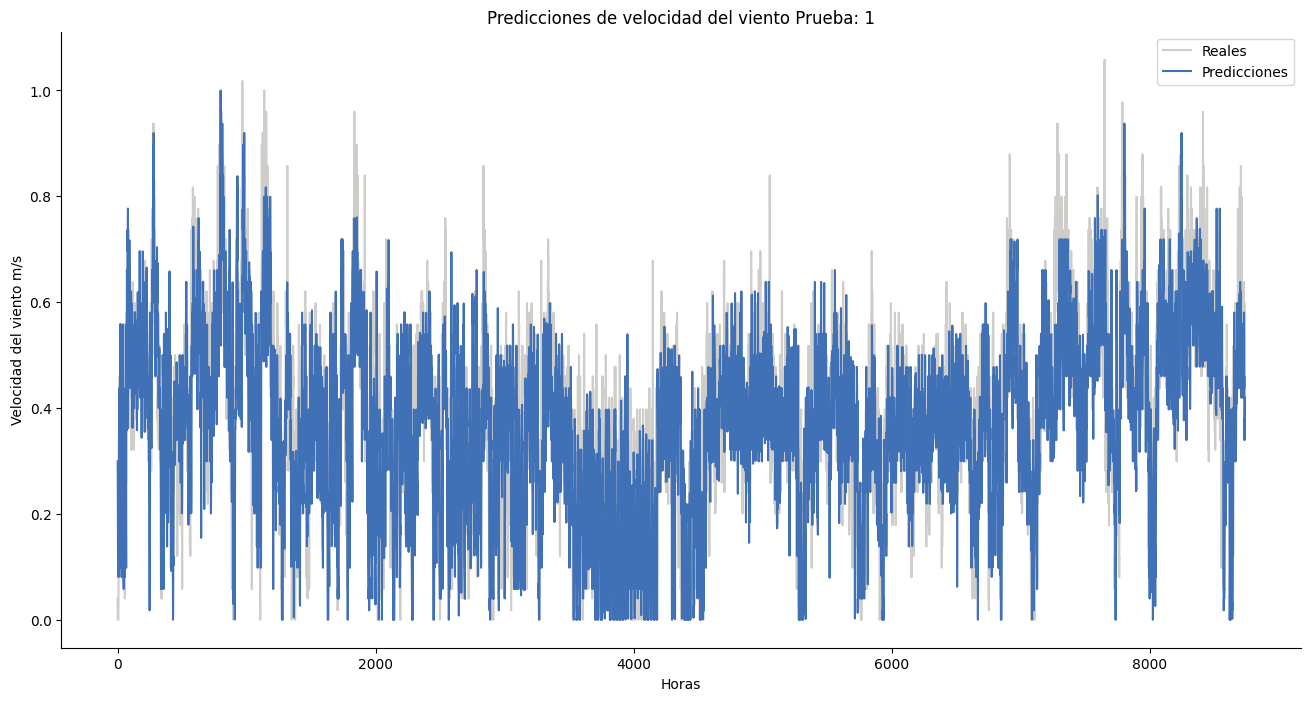

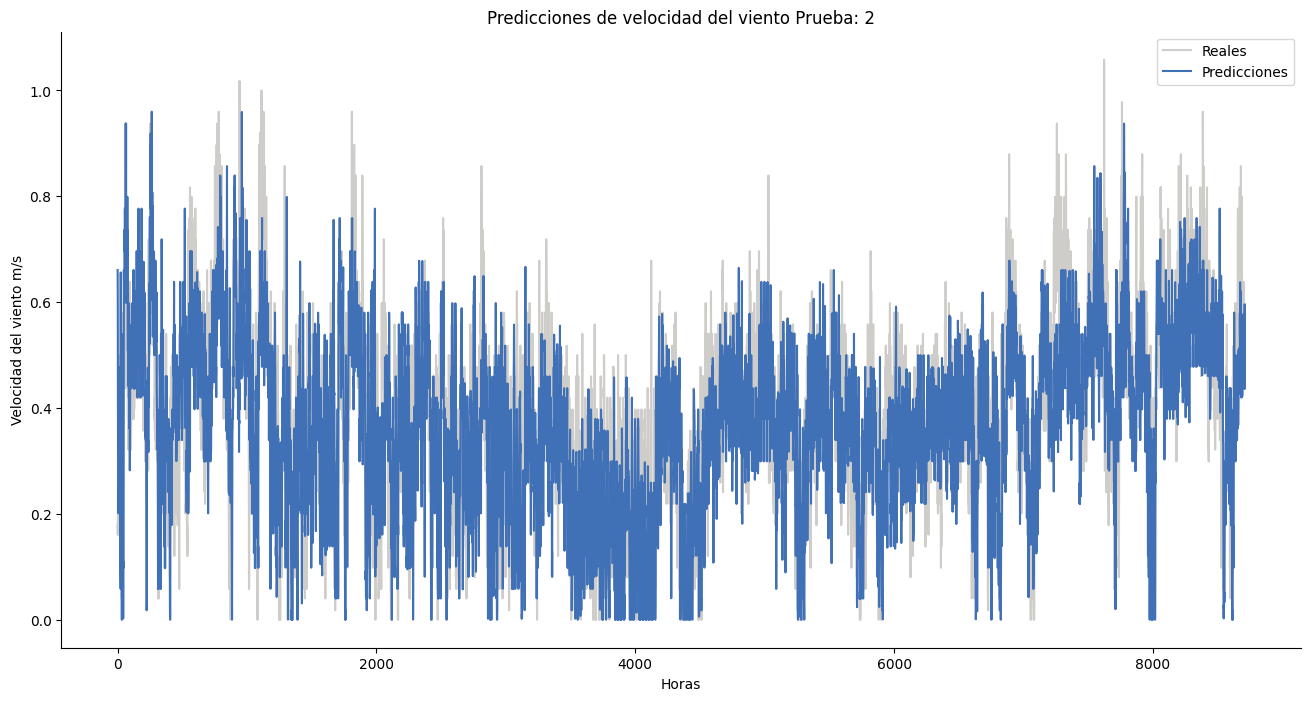

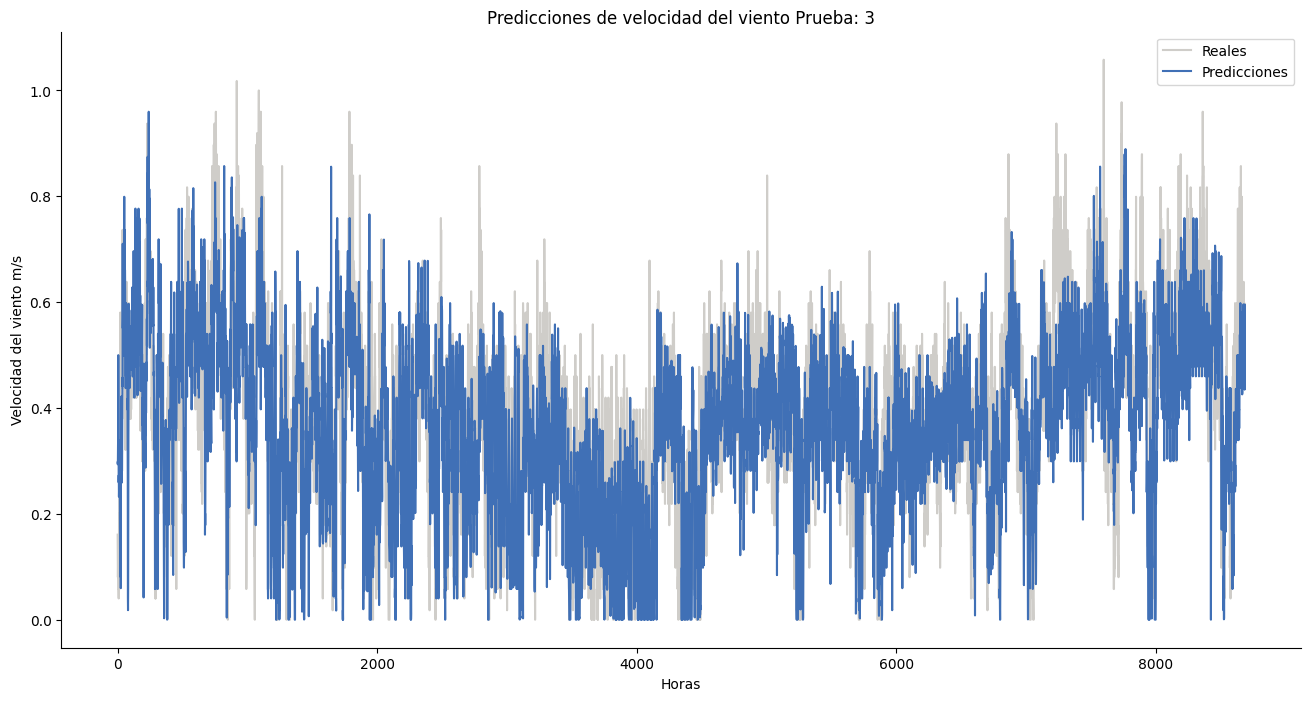

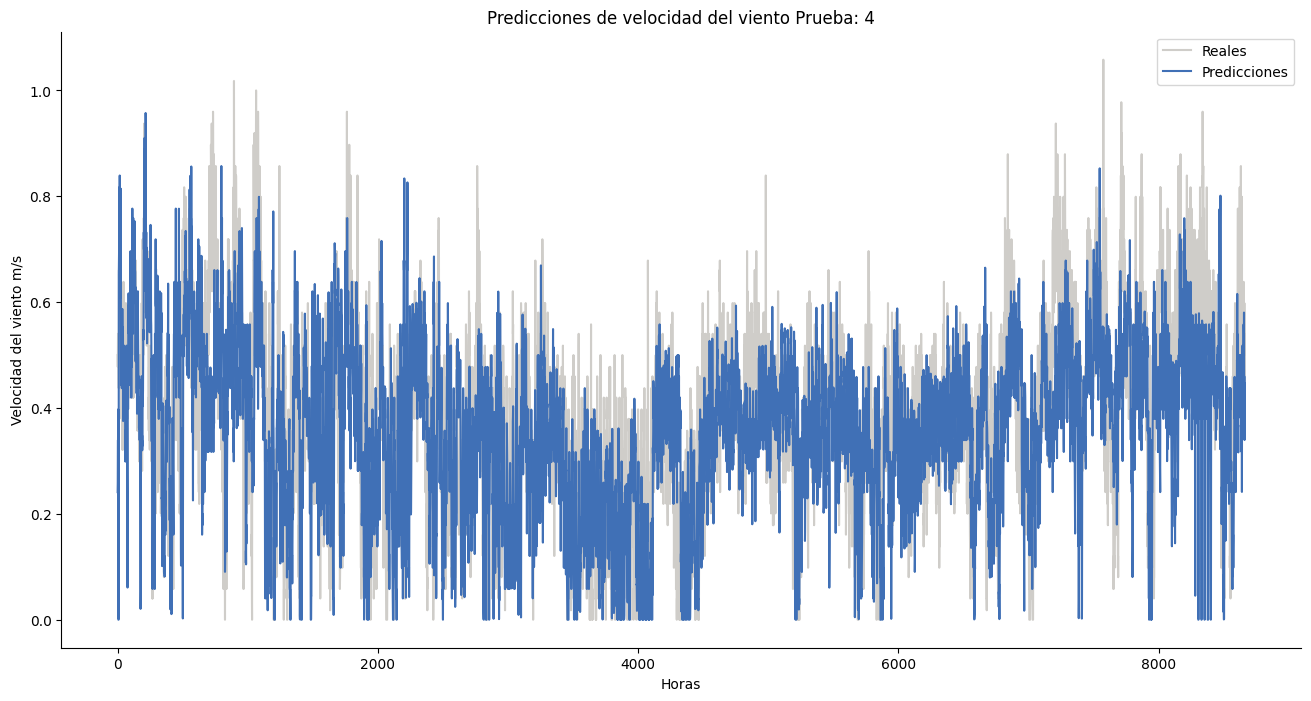

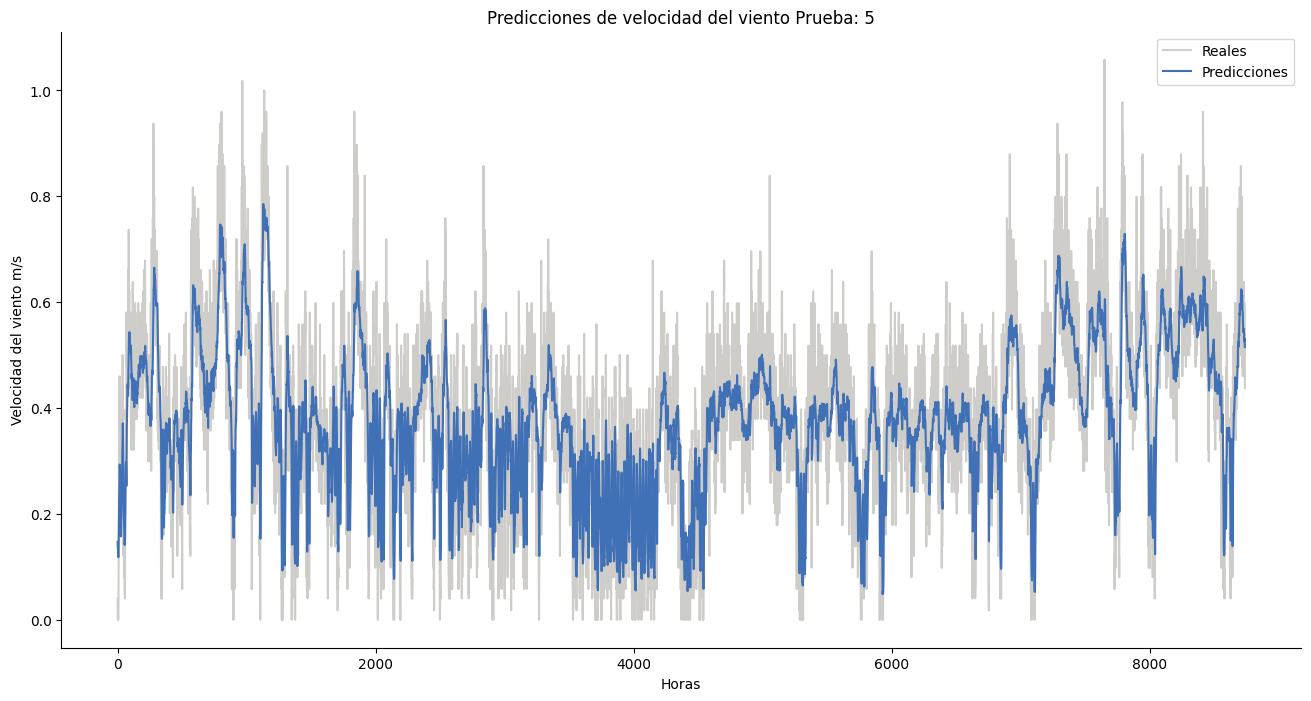

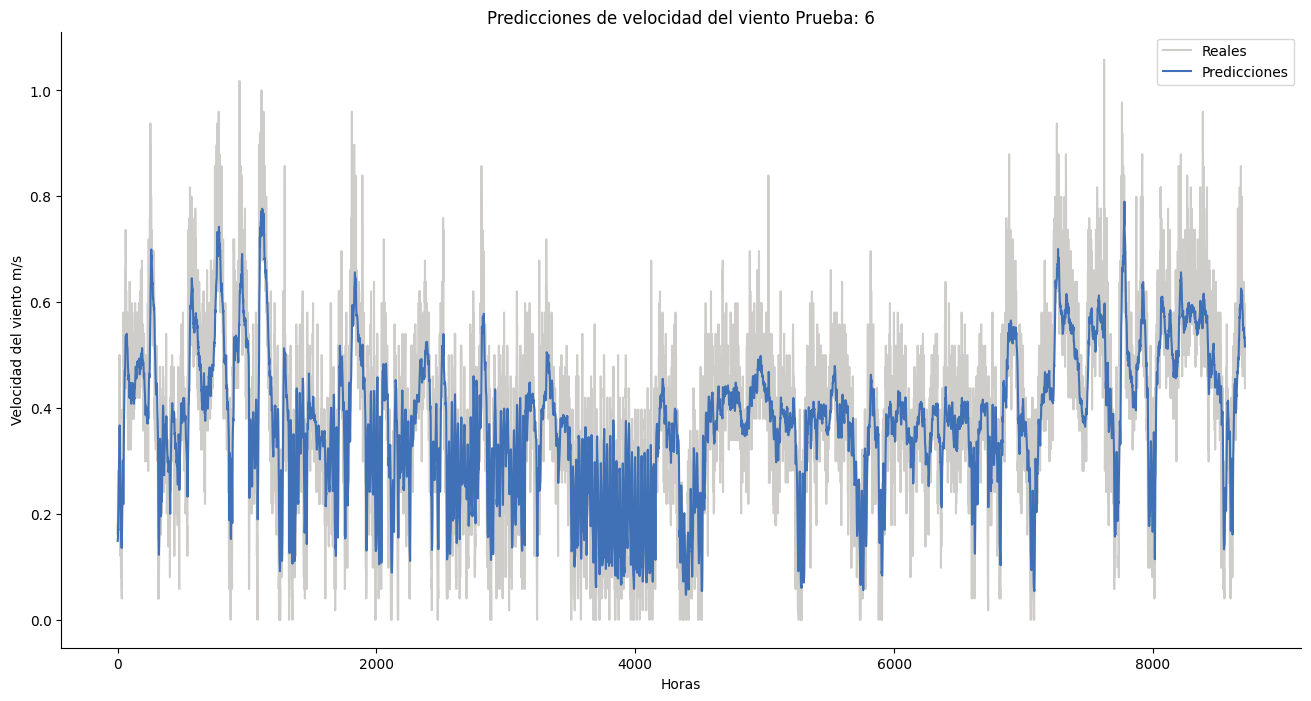

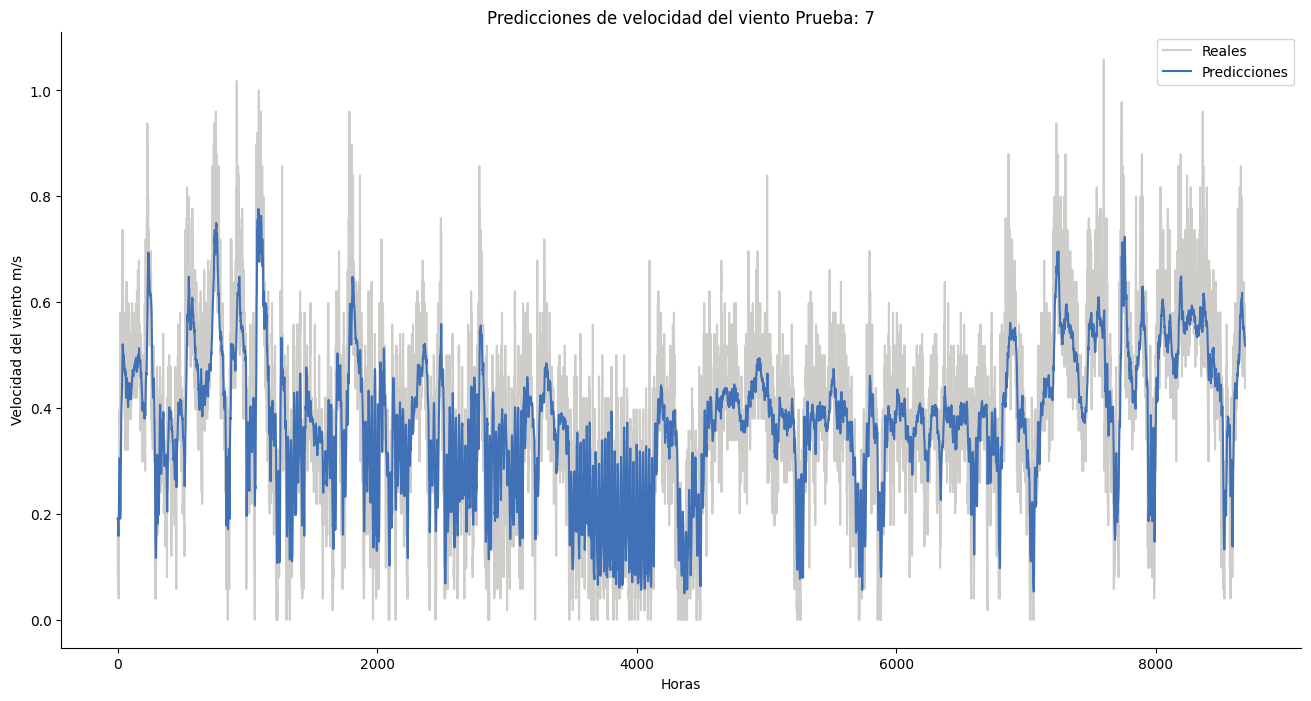

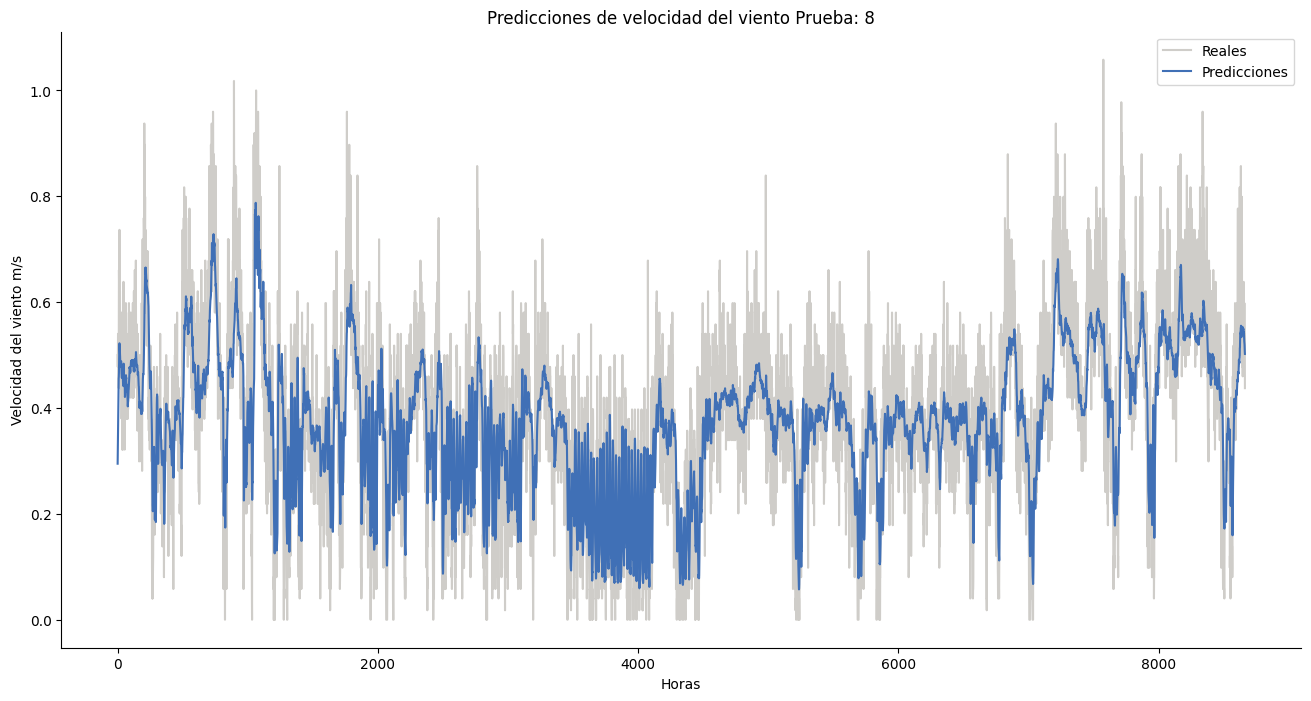

In [24]:
#model = algorithms.GRNN(std = 0.1, verbose=False)
minmax_scl = MinMaxScaler()
std_ = 0.0
for i, comb in enumerate(list_rect):
    df_ = df_Nizanda.copy()
    drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
    df_.drop(drop_cols, axis = 1, inplace = True)
    
    
    df_test = df_Prueba.copy()
    drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
    df_test.drop(drop_cols, axis = 1, inplace = True)
    
    minmax_scl.fit(df_)
    
    print('---Test Experiment: ', str(i + 1) + '---')
    
    #Entrenamiento
    w, n_cols = data_preprocessing(df_, minmax_scl)
    x_train, y_train = make_windows(w, input_size = comb[1], horizon = comb[2], shift = 0,  n_cols = n_cols)
    
    
    #Prueba
    w_test, n_cols = data_preprocessing(df_test, minmax_scl)
    x_test, y_test = make_windows(w_test, input_size = comb[1], horizon = comb[2], shift = 0,  n_cols = n_cols)
    
    
    if len(x_train.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_train.shape
        x_train = x_train.reshape((rows, nx*ny))
        
        rows, nx, ny = x_test.shape
        x_test = x_test.reshape((rows, nx*ny))
    
    while True:
        std_ += 0.05
        model = algorithms.GRNN(std = std_, verbose=False)
        model.train(x_train, y_train)
        y_pred = model.predict(x_test)
        
        if np.any(np.isnan(y_pred)) == False:
            print(std_)
            break
            
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared= False)
        
    plot_series(y_test, y_pred, title = 'Predicciones de velocidad del viento ' + 'Prueba: ' + str(i + 1))
    
    df_GRNN_test.loc[len(df_GRNN_test.index)] = ['GRNN', comb[2], r2, rmse, mae, [comb[0], comb[1], comb[2]]]
print('Runs experiment finished')

In [25]:
#D2023
df_GRNN_test

,Modelo,Horizon,R2,RSME,MAE,Params
0,GRNN,1,0.510841,0.122212,0.094836,"[[Month, Day, Hour, High Wind Speed m/s], 24, 1]"
1,GRNN,1,0.373786,0.138078,0.107288,"[[Month, Day, Hour, High Wind Speed m/s], 48, 1]"
2,GRNN,1,0.257343,0.150396,0.117095,"[[Month, Day, Hour, High Wind Speed m/s], 72, 1]"
3,GRNN,1,0.149886,0.160778,0.124981,"[[Month, Day, Hour, High Wind Speed m/s], 96, 1]"
4,GRNN,1,0.714998,0.093285,0.072706,"[[High Wind Speed m/s], 24, 1]"
5,GRNN,1,0.706658,0.094504,0.073144,"[[High Wind Speed m/s], 48, 1]"
6,GRNN,1,0.684094,0.098089,0.076037,"[[High Wind Speed m/s], 72, 1]"
7,GRNN,1,0.656852,0.102148,0.079183,"[[High Wind Speed m/s], 96, 1]"


In [21]:
df_GRNN_test

,Modelo,Horizon,R2,RSME,MAE,Params
0,GRNN,1,0.447212,0.134639,0.104482,"[[Month, Day, Hour, High Wind Speed m/s], 24, 1]"
1,GRNN,1,0.308504,0.150587,0.116605,"[[Month, Day, Hour, High Wind Speed m/s], 48, 1]"
2,GRNN,1,0.198247,0.161445,0.126711,"[[Month, Day, Hour, High Wind Speed m/s], 72, 1]"
3,GRNN,1,0.123998,0.168553,0.132608,"[[Month, Day, Hour, High Wind Speed m/s], 96, 1]"
4,GRNN,1,0.757743,0.089131,0.069516,"[[High Wind Speed m/s], 24, 1]"
5,GRNN,1,0.738101,0.092675,0.071736,"[[High Wind Speed m/s], 48, 1]"
6,GRNN,1,0.712516,0.096674,0.075187,"[[High Wind Speed m/s], 72, 1]"
7,GRNN,1,0.686370,0.100854,0.078505,"[[High Wind Speed m/s], 96, 1]"


In [27]:
df_GRNN_test.to_csv(r'C:\Users\Angel-PC\Documents\Tesis\Notebooks\Resultados\GRNN_Rec_test_2023.csv')

#### Simulacion de todos los meses REC

In [28]:
P_Enero = df_Prueba[df_Prueba['Month'] == 1]
P_Febrero = df_Prueba[df_Prueba['Month'] == 2]
P_Marzo = df_Prueba[df_Prueba['Month'] == 3]
P_Abril = df_Prueba[df_Prueba['Month'] == 4]
P_Mayo = df_Prueba[df_Prueba['Month'] == 5]
P_Junio = df_Prueba[df_Prueba['Month'] == 6]
P_Julio = df_Prueba[df_Prueba['Month'] == 7]
P_Agosto = df_Prueba[df_Prueba['Month'] == 8]
P_Septiembre = df_Prueba[df_Prueba['Month'] == 9]
P_Octubre = df_Prueba[df_Prueba['Month'] == 10]
P_Noviembre = df_Prueba[df_Prueba['Month'] == 11]
P_Diciembre = df_Prueba[df_Prueba['Month'] == 12]

Meses = {
    'Enero': P_Enero, 'Febrero': P_Febrero,
    'Marzo': P_Marzo, 'Abril': P_Abril,
    'Mayo': P_Mayo, 'Junio': P_Junio,
    'Julio': P_Julio, 'Agosto': P_Agosto, 
    'Septiembre': P_Septiembre, 'Octubre': P_Octubre, 
    'Novimebre': P_Noviembre, 'Diciembre': P_Diciembre
    }
keys = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Novimebre', 'Diciembre']

In [29]:
combi = list_rect[4]
print(combi)

(['High Wind Speed m/s'], 24, 1)


In [30]:
sns.set(rc={'figure.figsize':(14,5)})

NameError: name 'sns' is not defined

In [31]:
import warnings
warnings.filterwarnings('ignore')

combi = list_rect[4]
print(combi)

inicio = 0
if combi[1] == 24:
    inicio = 2
elif combi[1] == 48:
    inicio = 3
if combi[1] == 72:
    inicio = 4
elif combi[1] == 96:
    inicio = 5
#else:
    #inicio = -1

minmax_scl = MinMaxScaler()

df_ = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in combi[0]]
df_.drop(drop_cols, axis = 1, inplace = True)

minmax_scl.fit(df_)

w, n_cols = data_preprocessing(df_, minmax_scl)
x_train, y_train = make_windows(w, input_size = combi[1], horizon = combi[2], shift = 0,  n_cols = n_cols)
        
if len(x_train.shape) > 2:
    # Convertir a arreglo de 2 dimensiones
    rows, nx, ny = x_train.shape
    x_train = x_train.reshape((rows, nx*ny))    

model = algorithms.GRNN(std=0.1, verbose=False)
model.train(x_train, y_train)

for i, mes in enumerate(keys):
    df_mes = Meses[keys[i]]
    for j in range(inicio, len(df_mes['Day'].unique()) + 1):
        #Simulacion
        print(str(i + 1) + ' : ' + str(j))
        m, p, c, pred = simulation_v2(combi, (i + 1), j, model, minmax_scl)
        # Metricas
        r2 = r2_score(c, pred)
        mae = mean_absolute_error(c, pred)
        rmse = mean_squared_error(c, pred, squared= False)
        
        #Insertandolos en el Dataframe
        df_GRNN_sim.loc[len(df_GRNN_sim.index)] = [mes, j, r2, rmse, mae, 'GRNN', 'REC', combi, p]

(['High Wind Speed m/s'], 24, 1)
1 : 2
1 : 3
1 : 4
1 : 5
1 : 6
1 : 7
1 : 8
1 : 9
1 : 10
1 : 11
1 : 12
1 : 13
1 : 14
1 : 15
1 : 16
1 : 17
1 : 18
1 : 19
1 : 20
1 : 21
1 : 22
1 : 23
1 : 24
1 : 25
1 : 26
1 : 27
1 : 28
1 : 29
1 : 30
1 : 31
2 : 2
2 : 3
2 : 4
2 : 5
2 : 6
2 : 7
2 : 8
2 : 9
2 : 10
2 : 11
2 : 12
2 : 13
2 : 14
2 : 15
2 : 16
2 : 17
2 : 18
2 : 19
2 : 20
2 : 21
2 : 22
2 : 23
2 : 24
2 : 25
2 : 26
2 : 27
2 : 28
3 : 2
3 : 3
3 : 4
3 : 5
3 : 6
3 : 7
3 : 8
3 : 9
3 : 10
3 : 11
3 : 12
3 : 13
3 : 14
3 : 15
3 : 16
3 : 17
3 : 18
3 : 19
3 : 20
3 : 21
3 : 22
3 : 23
3 : 24
3 : 25
3 : 26
3 : 27
3 : 28
3 : 29
3 : 30
3 : 31
4 : 2
4 : 3
4 : 4
4 : 5
4 : 6
4 : 7
4 : 8
4 : 9
4 : 10
4 : 11
4 : 12
4 : 13
4 : 14
4 : 15
4 : 16
4 : 17
4 : 18
4 : 19
4 : 20
4 : 21
4 : 22
4 : 23
4 : 24
4 : 25
4 : 26
4 : 27
4 : 28
4 : 29
4 : 30
5 : 2
5 : 3
5 : 4
5 : 5
5 : 6
5 : 7
5 : 8
5 : 9
5 : 10
5 : 11
5 : 12
5 : 13
5 : 14
5 : 15
5 : 16
5 : 17
5 : 18
5 : 19
5 : 20
5 : 21
5 : 22
5 : 23
5 : 24
5 : 25
5 : 26
5 : 27
5 : 28
5 : 29

In [32]:
df_GRNN_sim

,Mes,Dia,R2,RMSE,MAE,Modelo,Metodo,Comb,Pronostico
0,Enero,2,0.201603,0.147060,0.129804,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[7.6, 6.7, 7.6, 8.0, 7.6, 10.3, 8.5, 10.7, 9.4..."
1,Enero,3,0.283920,0.088161,0.075078,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 2.2, ..."
2,Enero,4,-1.131456,0.245742,0.202586,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[4.0, 3.6, 4.9, 6.3, 5.8, 4.5, 4.9, 5.4, 3.6, ..."
3,Enero,5,-6.820862,0.200852,0.179219,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[3.6, 2.2, 1.8, 2.2, 2.2, 2.2, 1.3, 1.3, 0.9, ..."
4,Enero,6,-0.816865,0.110162,0.095862,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[11.2, 10.7, 11.6, 12.1, 12.1, 10.7, 10.7, 11...."
...,...,...,...,...,...,...,...,...,...
348,Diciembre,27,-0.461824,0.154443,0.136498,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[10.7, 8.9, 10.7, 12.5, 10.3, 8.5, 7.6, 8.5, 9..."
349,Diciembre,28,-14.353301,0.261682,0.236366,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[7.6, 7.2, 4.5, 2.2, 2.7, 1.8, 1.3, 1.8, 0.9, ..."
350,Diciembre,29,-2.606743,0.171532,0.147515,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[7.2, 9.8, 10.3, 9.8, 10.3, 8.9, 11.2, 11.6, 1..."
351,Diciembre,30,-0.625252,0.117981,0.096757,GRNN,REC,"([High Wind Speed m/s], 24, 1)","[9.4, 10.7, 12.1, 12.1, 9.8, 8.9, 10.7, 9.8, 9..."


In [33]:
df_GRNN_sim_rec = df_GRNN_sim[df_GRNN_sim['Metodo'] == 'REC']

In [34]:
sns.boxplot(data = df_GRNN_sim_rec, x = 'Mes', y = 'R2', hue='Mes')

NameError: name 'sns' is not defined

<Axes: xlabel='Mes', ylabel='RMSE'>

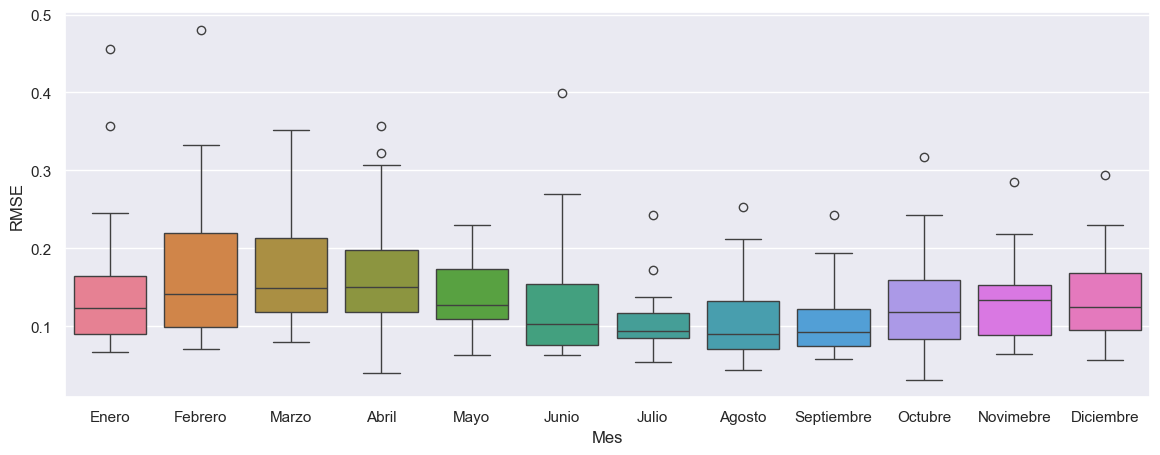

In [48]:
sns.boxplot(data = df_GRNN_sim_rec, x = 'Mes', y = 'RMSE', hue='Mes')

<Axes: xlabel='Mes', ylabel='MAE'>

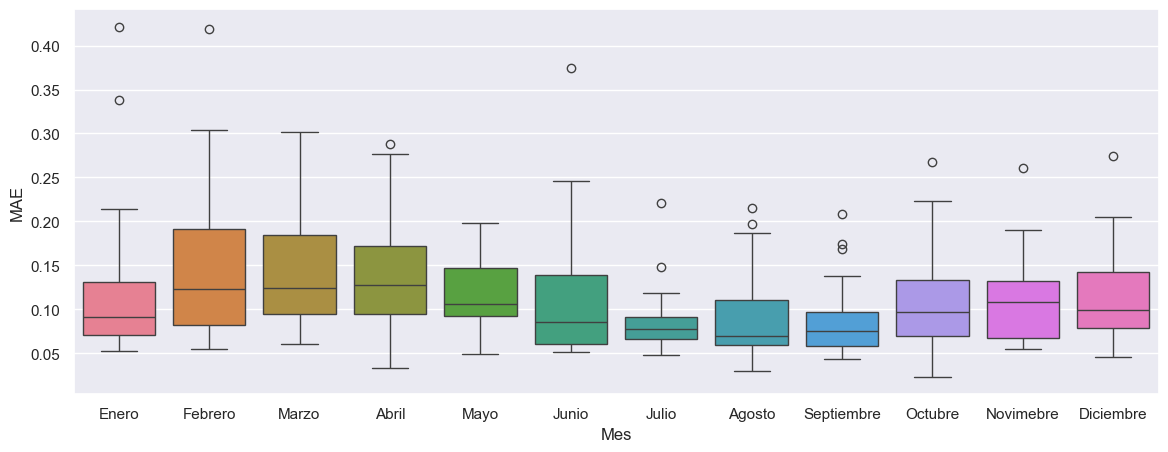

In [49]:
sns.boxplot(data = df_GRNN_sim_rec, x = 'Mes', y = 'MAE', hue='Mes')

In [36]:
df_GRNN_sim.to_csv(r'C:\Users\Angel-PC\Documents\Tesis\Notebooks\Resultados\GRNN_Rec_sim_2023.csv')